# Assignment 2: Twitter Networks

Module: **COMP30850 Network Analysis (Spring 2021)**  
Name: **Rajit Banerjee**  
Student Number: **18202817**  
Data: `./data/technology/`

Aim: To construct and characterise a range of network representations, created from pre-collected Twitter data for  a specific Twitter List on *technology*.

1. [Follower Network](#Follower-Network)
2. [Reply Network](#Reply-Network)
3. [Mention Network](#Mention-Network)
4. [User-hashtag Network](#User-hashtag-Network)
5. [Hashtag Co-occurrence Network](#Hashtag-Co-occurrence-Network)

## Follower Network

The most basic type of Twitter network we can create is one that represents the follower relations between accounts in our list. The `friendships.csv` file is an edgelist with two tab-separated columns X, Y: indicating that user X follows Y; this can be used to construct our follower network.

### Construction

In [1]:
from typing import Union

import networkx as nx
import numpy as np
import pandas as pd

pd.set_option('display.precision', 3)

friendships = './data/technology/friendships.csv'
follow_net = nx.read_edgelist(friendships, delimiter='\t',
                              create_using=nx.DiGraph)

### Structural Characteristics

This is an **unweighted, directed network**, on which we can perform various characterisation steps. 

- Network **size** is simply the count of nodes and edges.
- Network **density** refers to the portion of potential edges between nodes in a network that exist as actual edges.
- A directed graph is **strongly connected** if and only if every vertex in the graph is reachable from every other vertex. Otherwise, it may contain a number of strongly connected components (subgraphs) with the required reachability property. 
- A directed graph is **weakly connected** if and only if the graph is connected when the direction of the edge between nodes is ignored.
- Clustering coefficient of a node is the fraction of pairs of its neighbours that have edges between one another, i.e., the number of closed triangles around this node. The **average clustering coefficient** indicates the level of clustering across the entire network.
- **Reciprocity** is a measure of the fraction of reciprocated edges in a directed network, i.e., the ratio of the number of edges pointing in both directions to the total number of edges in the network.

In [2]:
# structural characteristics for directed/undirected networks
def basic_chars(net: Union[nx.Graph, nx.DiGraph]) -> None:
    print(f'Number of nodes: {net.number_of_nodes()}')
    print(f'Number of edges: {net.number_of_edges()}')
    print(f'Network density: {nx.density(net):.3f}')
    print('Average clustering coefficient: ' +
          f'{nx.average_clustering(net):.3f}')


# characteristics of directed networks
def directed_chars(net: nx.DiGraph, degrees: bool = True) -> None:
    print('Number of strongly connected components: ' +
          f'{nx.number_strongly_connected_components(net)}')
    print('Number of weakly connected components: ' +
          f'{nx.number_weakly_connected_components(net)}')
    print(f'Reciprocity: {nx.reciprocity(net):.3f}')
    if degrees:
        print('Average in-degree: ' +
              f'{pd.Series(dict(net.in_degree())).mean():.3f}')
        print('Average out-degree: ' +
              f'{pd.Series(dict(net.out_degree())).mean():.3f}')


basic_chars(follow_net)
directed_chars(follow_net, degrees=False)

Number of nodes: 29
Number of edges: 203
Network density: 0.250
Average clustering coefficient: 0.444
Number of strongly connected components: 8
Number of weakly connected components: 1
Reciprocity: 0.345


We find that there are 29 nodes representing Twitter users in the list, and 203 directed edges representing the follower relations. The entire network is only connected if the edge directions are ignored (weak connectivity).

### In-degree Distribution

The concept of 'influence' of a Twitter user can be quantified using the **in-degree** measure of a node, i.e., the number of incoming edges (number of followers *within* the network; not considering the rest of Twitter).

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# compute and sort node in-degrees (optionally weighted)
def get_in_deg(net: nx.DiGraph, weight: str = None) -> pd.DataFrame:
    title = 'in_degree' if not weight else 'win_degree'
    in_deg_s = pd.Series(dict(net.in_degree(weight=weight)),
                         name=title).sort_values(ascending=False)
    return pd.DataFrame(in_deg_s)


in_deg1 = get_in_deg(follow_net)
in_deg1.head()

,in_degree
mashable,15
wired,13
techmeme,13
techcrunch,12
engadget,11


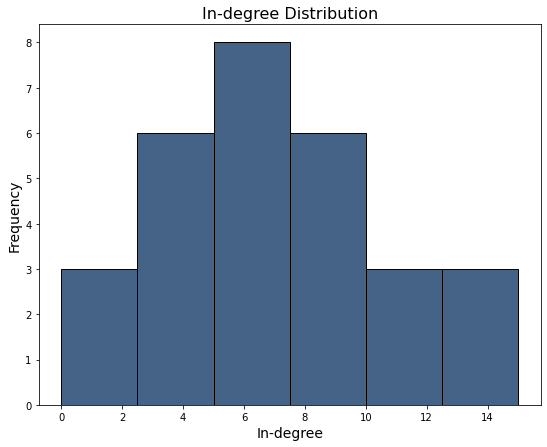

In [4]:
plt.figure(figsize=(9, 7))
sns.histplot(data=in_deg1, x='in_degree', color='#072f5f')
plt.title('In-degree Distribution', fontsize=16)
plt.xlabel('In-degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

The above histogram shows the count of different in-degree measures for nodes in the network. We can also rank the individual nodes as follows:

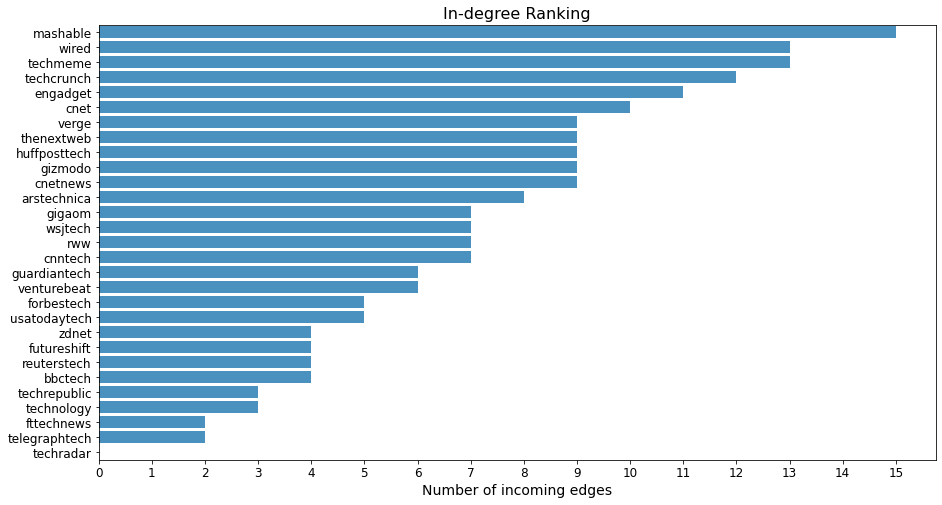

In [5]:
plt.figure(figsize=(15, 8))
sns.barplot(data=in_deg1, x='in_degree', y=in_deg1.index, color='#3895d3')
plt.title('In-degree Ranking', fontsize=16)
plt.xlabel('Number of incoming edges', fontsize=14)
plt.xticks(range(max(in_deg1['in_degree'])+1))
plt.tick_params(labelsize=12)
plt.show()

It is clear that `@mashable` is followed by the most number of accounts (15) of the 29 users in the network, which suggests that it is a popular account even among other technology news accounts on Twitter.

### Ego-centric Analysis

Taking the node with the largest in-degree (`@mashable`), we can perform ego-centric analysis and display an ego network, i.e., a node's direct connections as well as connections between those nodes.

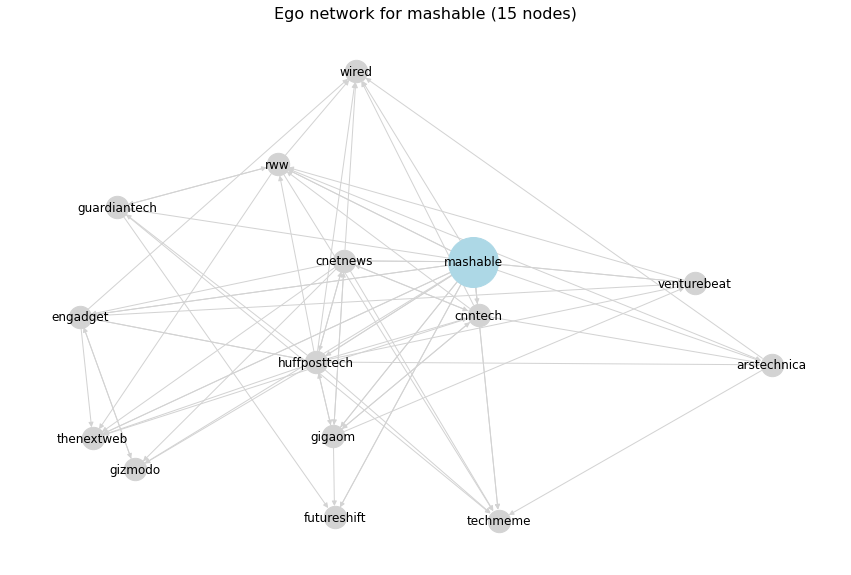

Ego: mashable
Number of nodes: 15
Number of edges: 72
Network density: 0.343
Average clustering coefficient: 0.568
Number of strongly connected components: 4
Number of weakly connected components: 1
Reciprocity: 0.472
Average in-degree: 4.800
Average out-degree: 4.800


In [6]:
# display ego network and some of its basic structural characteristics
def ego_analysis(net: Union[nx.Graph, nx.DiGraph], ego: str, ego_color: str,
                 size: str = 'medium', with_labels: bool = True,
                 k: int = 2) -> Union[nx.Graph, nx.DiGraph]:
    # create ego network and set layout
    eg = nx.ego_graph(net, ego)
    pos = nx.spring_layout(net, k=k)

    if size == 'large':
        plt.figure(figsize=(20, 20))
    elif size == 'small':
        plt.figure(figsize=(8, 5))
    elif size == 'medium':
        plt.figure(figsize=(15, 10))

    title = f'Ego network for {ego} ({eg.number_of_nodes()} nodes)'
    plt.title(title, fontsize=16)

    # draw the full network
    nx.draw_networkx(eg, pos, with_labels=with_labels, font_size=12,
                     node_size=500, node_color='lightgrey', edge_color='lightgrey')

    # draw the ego in a different colour with larger node size
    nx.draw_networkx_nodes(eg, pos, nodelist=[ego],
                           node_size=2500, node_color=ego_color)
    plt.axis('off')
    plt.show()

    # display network characteristics
    print(f'Ego: {ego}')
    basic_chars(eg)
    if type(eg) is nx.Graph:
        undirected_chars(eg)
    else:
        directed_chars(eg)

    return eg


follow_eg = ego_analysis(follow_net, 'mashable', ego_color='lightblue')

### Undirected Network

A new undirected network containing only the reciprocated edges can be created and visualised. Any isolated nodes are removed.

- A **connected** network is one with a path between every pair of nodes.
- The **diameter** of a network is the length of the longest shortest path between any pair of nodes in the network.
- The **average shortest path length** between nodes of the network is another important measure of connectivity.

In [7]:
follow_net_undir = follow_net.to_undirected(reciprocal=True)
follow_net_undir.remove_nodes_from(list(nx.isolates(follow_net_undir)))


# characteristics of undirected networks
def undirected_chars(net: nx.Graph) -> None:
    print('Average degree: ' +
          f'{pd.Series(dict(net.degree())).mean():.3f}')

    comp = nx.number_connected_components(net)
    print(f'Number of connected components: {comp}')
    if comp == 1:
        # single component
        print(f'Diameter: {nx.diameter(net)}')
        print('Average shortest path length: ' +
              f'{nx.average_shortest_path_length(net):.3f}')
    else:
        # multiple connected components
        comps = sorted(list(len(component)
                            for component in nx.connected_components(net)))
        print(f'Number of nodes in largest component: {comps[-1]}')


undirected_chars(follow_net_undir)

Average degree: 3.500
Number of connected components: 1
Diameter: 5
Average shortest path length: 2.447


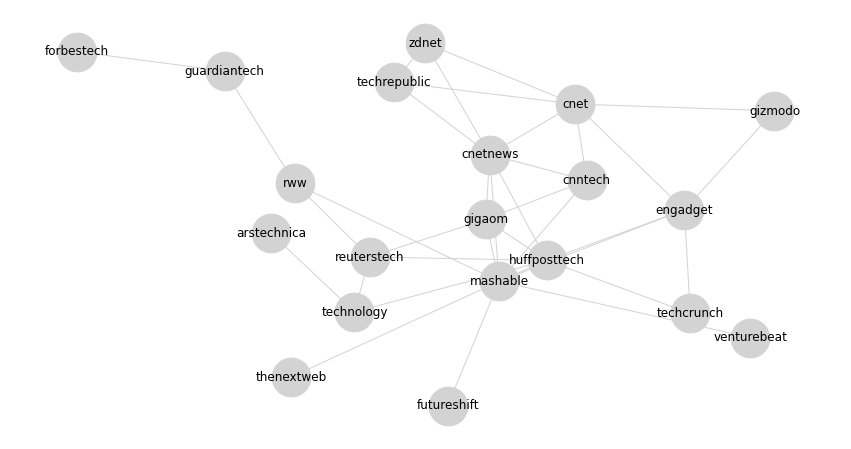

In [8]:
plt.figure(figsize=(15, 8))
plt.margins(0.1, 0.1)
pos = nx.spring_layout(follow_net_undir, k=0.75)
nx.draw(follow_net_undir, pos, with_labels=True, font_size=12,
        node_size=1500, node_color='lightgrey', edge_color='lightgrey')

### Twitter Followers Ranking

The influence that the accounts have on Twitter at large can be found by parsing the user profile JSON lines file `list_members.jsonl`, and ranking users by their follower count.

In [9]:
import json

with open('./data/technology/list_members.jsonl') as f:
    profile_df = pd.DataFrame([json.loads(line.strip()) for line in f])

f'Rows: {len(profile_df)}', profile_df.columns

('Rows: 29',
 Index(['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url',
        'entities', 'protected', 'followers_count', 'friends_count',
        'listed_count', 'created_at', 'favourites_count', 'utc_offset',
        'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang',
        'status', 'contributors_enabled', 'is_translator',
        'is_translation_enabled', 'profile_background_color',
        'profile_background_image_url', 'profile_background_image_url_https',
        'profile_background_tile', 'profile_image_url',
        'profile_image_url_https', 'profile_banner_url', 'profile_link_color',
        'profile_sidebar_border_color', 'profile_sidebar_fill_color',
        'profile_text_color', 'profile_use_background_image',
        'has_extended_profile', 'default_profile', 'default_profile_image',
        'following', 'follow_request_sent', 'notifications', 'translator_type'],
       dtype='object'))

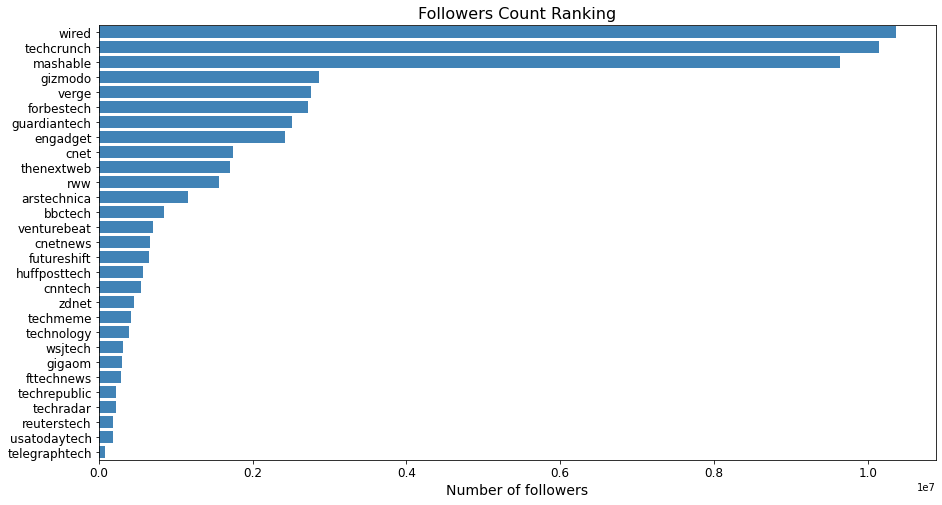

In [10]:
profile_df['screen_name'] = profile_df['screen_name'].str.lower()

plt.figure(figsize=(15, 8))
sns.barplot(data=profile_df[['screen_name', 'followers_count']].
            sort_values(by='followers_count',
                        ascending=False),
            x='followers_count',
            y='screen_name',
            color='#2e86c9')
plt.title('Followers Count Ranking', fontsize=16)
plt.ylabel(None)
plt.xlabel('Number of followers', fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

The number of followers for the top three accounts `@wired`, `@techcrunch` and `@mashable`, far exceed those for the  other accounts in the list (approximately 5x the count for the 4th account in the network).

### Network Visualisation 

The entire follower network can be visualised in Gephi, with the node size and labels scaled by in-degree value.

In [11]:
nx.write_gexf(follow_net, './out/follow_net.gexf', prettyprint=True)

<img src='./out/follow_net.png' width='1000'>

Image: `./out/follow_net.png`

## Reply Network

A reply network is a **weighted, directed network** for a collection of tweets, such that each node is a Twitter account, and an edge from user X to Y signifies that X has replied to Y, with the edge weight representing the number of such replies.

### Construction

First, we must parse the JSON lines file containing all the collected tweets.

In [12]:
with open('./data/technology/tweets.jsonl') as f:
    tweets_df = pd.DataFrame(json.loads(line.strip()) for line in f)

f'Rows: {len(tweets_df)}', tweets_df.columns

('Rows: 14500',
 Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
        'display_text_range', 'entities', 'source', 'in_reply_to_status_id',
        'in_reply_to_status_id_str', 'in_reply_to_user_id',
        'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
        'coordinates', 'place', 'contributors', 'is_quote_status',
        'retweet_count', 'favorite_count', 'favorited', 'retweeted',
        'possibly_sensitive', 'lang', 'extended_entities', 'retweeted_status',
        'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
        'quoted_status'],
       dtype='object'))

From the DataFrame containing all tweets, we need to extract only the relevant pair of columns for a reply network: the handle of the user who authored the tweet, and the handle of the user who is being replied to. A filtering step is applied to obtain only the tweets which are indeed replies. Screen names are converted to lowercase for convenience, just like the [follower network](#Follower-Network) earlier.

In [13]:
reply_df = tweets_df[['user', 'in_reply_to_screen_name']].copy()
reply_df = reply_df[reply_df['in_reply_to_screen_name'].notnull()]
reply_df['in_reply_to_screen_name'] = reply_df['in_reply_to_screen_name'].str.lower()

reply_df['user'] = reply_df['user'].apply(lambda u: u['screen_name'].lower())
reply_df

,user,in_reply_to_screen_name
24,telegraphtech,telegraphtech
86,reuterstech,reuterstech
409,reuterstech,reuterstech
742,gigaom,jonno
847,reuterstech,reuterstech
...,...,...
14130,techrepublic,greg_ronayne
14154,techradar,techradar
14163,telegraphtech,telegraphtech
14249,telegraphtech,telegraphtech


Now, we need to group the identical pairs and count them, in order to calculate the number of replies for each ordered pair.

In [14]:
reply_df = pd.DataFrame(reply_df.value_counts(), columns=['num_replies'])
reply_df.reset_index(inplace=True)
reply_df.head(10)

,user,in_reply_to_screen_name,num_replies
0,telegraphtech,telegraphtech,57
1,reuterstech,reuterstech,37
2,cnet,cnet,24
3,techradar,techradar,9
4,wired,wired,8
5,bbctech,bbctech,6
6,cnntech,cnntech,4
7,engadget,engadget,2
8,usatodaytech,usatodaytech,2
9,techrepublic,godinho_nuno,2


It is interesting to note that the top 9 rows in the table above are all instances of users replying to their own tweets.

Finally, our weighted, directed reply network can be created from the edgelist. Here, the nodes are either present in the technology list, or they are users from the wider Twitter platform, i.e., users who are not necessarily members  of  the  list,  but have received replies from users on the list.

In [15]:
reply_net = nx.from_pandas_edgelist(reply_df, source='user', target='in_reply_to_screen_name',
                                    edge_attr='num_replies', create_using=nx.DiGraph)

### Structural Characteristics

The functions written earlier to compute network characteristics can be re-used here.

In [16]:
basic_chars(reply_net)
directed_chars(reply_net)

Number of nodes: 39
Number of edges: 35
Network density: 0.024
Average clustering coefficient: 0.000
Number of strongly connected components: 39
Number of weakly connected components: 14
Reciprocity: 0.000
Average in-degree: 0.897
Average out-degree: 0.897


On computing basic characteristics of the network, it is interesting to note a negligible density value, and nil scores for both reciprocity and average clustering coefficient. Zero reciprocity specifically means that for any user X replying to Y from the collected tweets, there is no instance of Y replying to X. Also, there are as many strongly connected components as there are nodes (39). This sheds light on the extreme sparsity and low connectivity in the reply network.

### Degree Distributions

Apart from the average in-degree/out-degree measures shown above, we can plot their respective overall distributions.

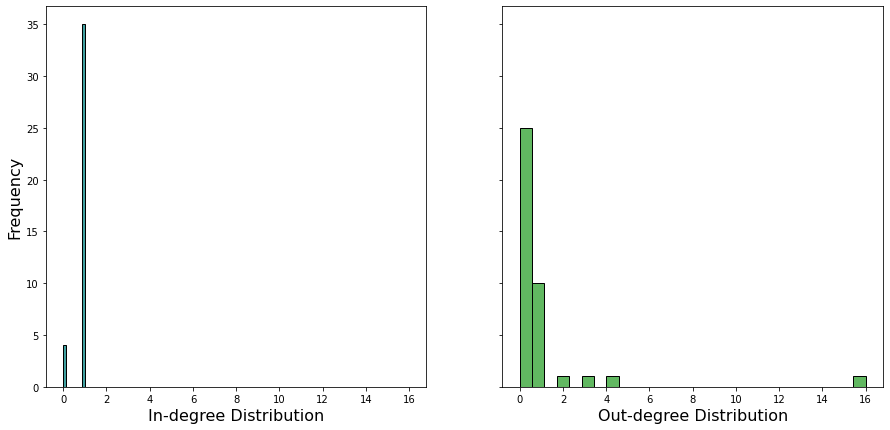

In [17]:
# compute and sort node out-degrees (optionally weighted)
def get_out_deg(net: nx.DiGraph, weight: str = None) -> pd.DataFrame:
    title = 'out_degree' if not weight else 'wout_degree'
    out_deg_s = pd.Series(dict(net.out_degree(weight=weight)),
                          name=title).sort_values(ascending=False)
    return pd.DataFrame(out_deg_s)


in_deg2 = get_in_deg(reply_net)
out_deg2 = get_out_deg(reply_net)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               figsize=(15, 7), sharex=True, sharey=True)
sns.histplot(data=in_deg2, x='in_degree', color='teal', ax=ax1)
ax1.set_xlabel('In-degree Distribution', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)

sns.histplot(data=out_deg2, x='out_degree', color='tab:green', ax=ax2)
ax2.set_xlabel('Out-degree Distribution', fontsize=16)
plt.show()

In [18]:
in_deg2.head(10)

,in_degree
telegraphtech,1
reuterstech,1
gamer_gurl99,1
ashcrafttrey07,1
javiksis,1
ianmorris78,1
afrohacker,1
thelimeloop,1
brubawil87,1
corinne_ballard,1


For in-degree distribution, the vast majority of accounts in the network have an in-degree of 1, and some are nil. This means that in the given network, most accounts receive replies from at most one account (usually themselves).  

In [19]:
out_deg2.head(10)

,out_degree
cnet,16
techradar,4
thenextweb,3
techrepublic,2
telegraphtech,1
gigaom,1
reuterstech,1
mashable,1
techcrunch,1
usatodaytech,1


In case of out-degree distribution, only a few accounts like `@cnet`, `@techradar` (and a couple others), have replied to multiple other Twitter users in the network. This reiterates the observation from earlier, that users in the technology network usually only reply to their own tweets.

### Ego-centric Analysis

Deciding on what charactertises an _important_ node in the reply network is difficult. Nodes such as `@telegraphtech` and `@reuterstech` which have received the most number of replies, have done so _only_ from their own accounts. Moreover, due to the low connectivity in the network, performing further centrality analysis (such as betweenness, closeness, eigenvector) isn't beneficial. Hence, it seems more appropriate to look at `@cnet` and `@techradar`, which have the top two unweighted out-degree scores, i.e., they have replied to more distinct Twitter accounts compared to other nodes in the network.

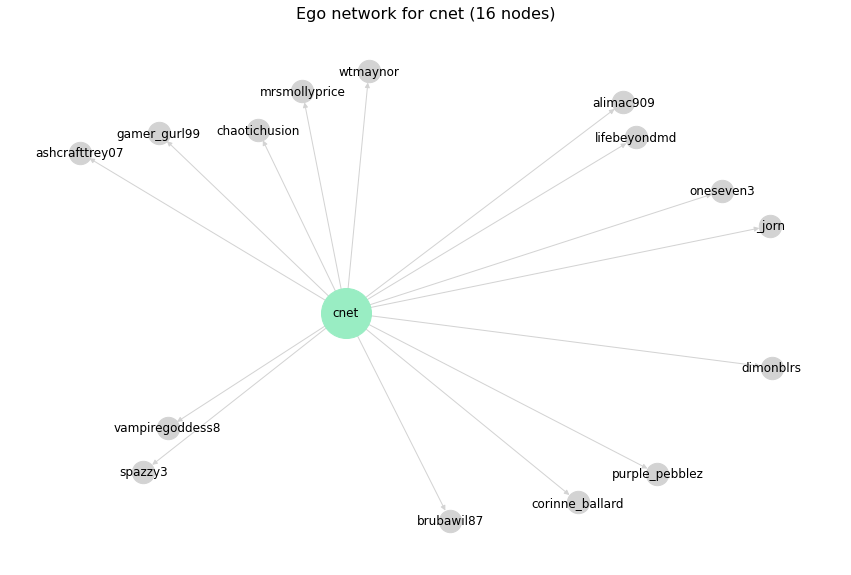

Ego: cnet
Number of nodes: 16
Number of edges: 16
Network density: 0.067
Average clustering coefficient: 0.000
Number of strongly connected components: 16
Number of weakly connected components: 1
Reciprocity: 0.000
Average in-degree: 1.000
Average out-degree: 1.000


In [20]:
reply_eg1 = ego_analysis(reply_net, 'cnet', ego_color='#99edc3')

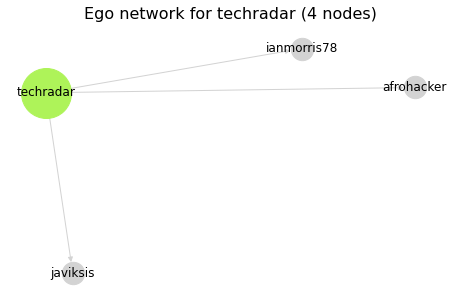

Ego: techradar
Number of nodes: 4
Number of edges: 4
Network density: 0.333
Average clustering coefficient: 0.000
Number of strongly connected components: 4
Number of weakly connected components: 1
Reciprocity: 0.000
Average in-degree: 1.000
Average out-degree: 1.000


In [21]:
reply_eg2 = ego_analysis(reply_net, 'techradar',
                         ego_color='#aef359', size='small', k=1)

The lack of connections between alters is expected, since the tweets were collected for the accounts in the Twitter list, and not for all the accounts being replied to, from Twitter at large.

### Network Visualisation

Visualisation can be performed in NetworkX itself, using a shell layout. As expected, most edges emerge from a handful of nodes, and self-loops are not represented.

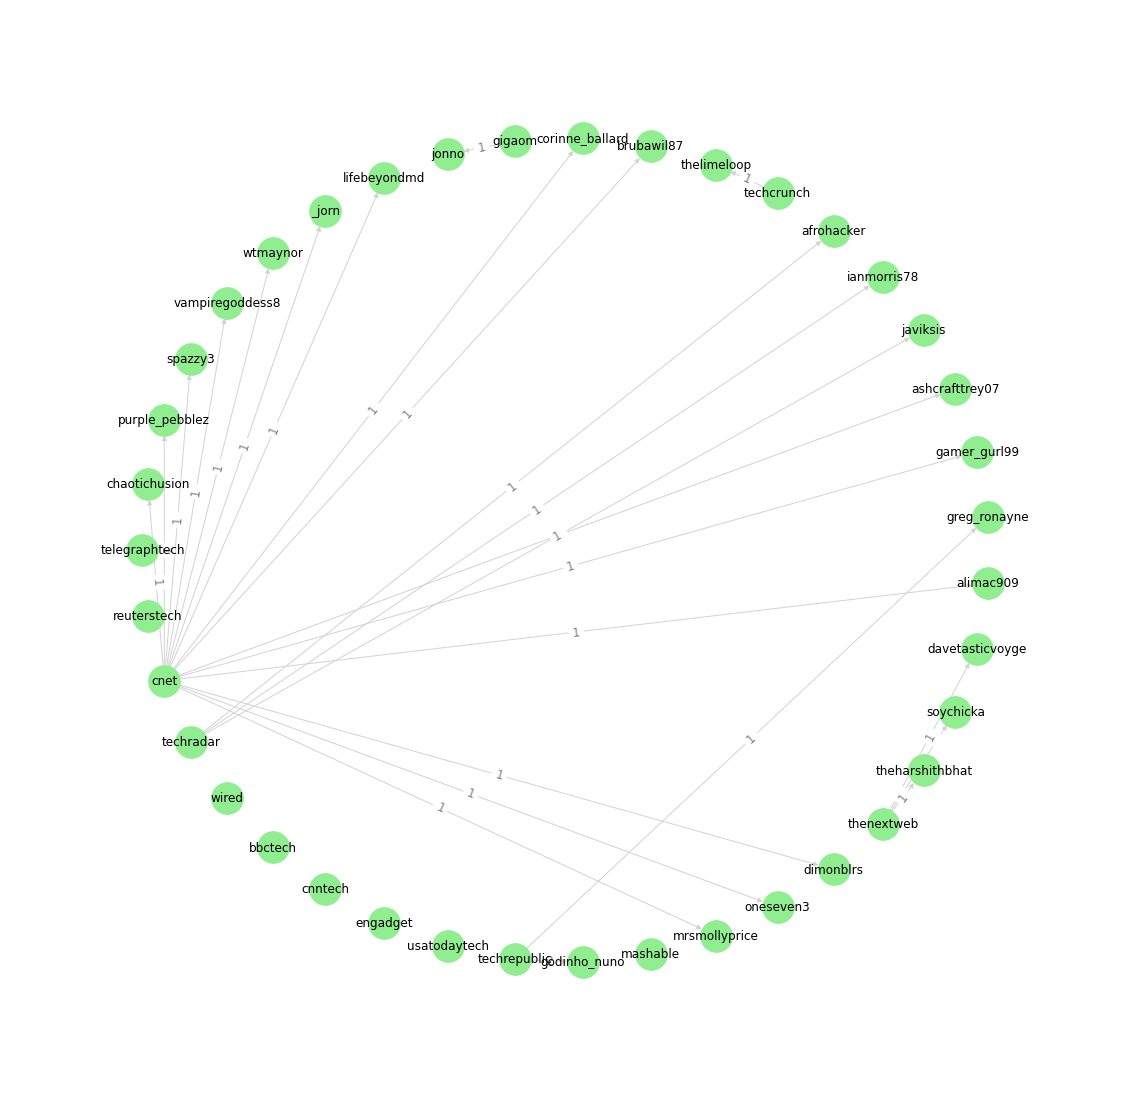

In [22]:
plt.figure(figsize=(20, 20))
plt.margins(0.1, 0.1)
pos = nx.shell_layout(reply_net)
labels = nx.get_edge_attributes(reply_net, 'num_replies')

nx.draw_networkx(reply_net, pos, font_size=12, node_size=1000,
                 node_color='lightgreen', edge_color='lightgrey')
nx.draw_networkx_edge_labels(
    reply_net, pos, edge_labels=labels, font_size=12, font_color='grey')
plt.axis('off')
plt.show()

## Mention Network

A mention network is a **weighted, directed network**, used to study another form of interaction between Twitter users: the ability to mention other users in tweets using the @-notation. Here, nodes are users, directed edges denote direction of mentions between users, and edge weights
correspond to mention frequency.

### Construction

Network construction is similar to the [reply network](#Reply-Network). The relevant columns from the entire tweets DataFrame are copied. The list of mentioned screen names are extracted, and the tweets without any mentions are filtered out. The tweet authors' screen names, as well as the mentioned users' screen names are converted to lowercase.

In [23]:
mention_df = tweets_df[['user', 'entities']].copy()

mention_df['user_mentions'] = mention_df['entities'].apply(
    lambda e: e['user_mentions'])

mention_df.drop(['entities'], axis=1, inplace=True)
mention_df = mention_df[mention_df['user_mentions'].map(len) != 0]

mention_df['user_mentions'] = mention_df['user_mentions'].apply(
    lambda x: [u['screen_name'].lower() for u in x])

mention_df['user'] = mention_df['user'].apply(
    lambda u: u['screen_name'].lower())

mention_df

,user,user_mentions
6,arstechnica,[dangoodin001]
7,techcrunch,[kirstenkorosec]
14,forbestech,"[rebecca_szkutak, forbes]"
16,gigaom,[signoretti]
21,rww,[mashable]
...,...,...
14490,technology,[emilychangtv]
14495,techmeme,[lilyhnewman]
14496,cnet,[trickholland]
14497,zdnet,[chrismatyszczyk]


The DataFrame thus obtained can be further transformed using the `explode()` function, which splits the lists of user mentions into multiple rows containing a single user each. Then, the frequency of all the unique _tweet author - mentioned user_ pairs are computed, which yields the required edge weights for the network.

In [24]:
mention_df = mention_df.explode('user_mentions')
mention_df = pd.DataFrame(mention_df.value_counts(), columns=['num_mentions'])
mention_df.reset_index(inplace=True)
mention_df.head()

,user,user_mentions,num_mentions
0,gizmodo,gizmodo,110
1,thenextweb,indianidle,87
2,thenextweb,thomas_macaulay,77
3,gigaom,stoweboyd,65
4,gigaom,esignoretti,65


The edgelist can now be used to create a weighted, directed network.

In [25]:
mention_net = nx.from_pandas_edgelist(mention_df, source='user', target='user_mentions',
                                      edge_attr='num_mentions', create_using=nx.DiGraph)

### Structural Characteristics

Similar to previous networks, the structural characteristics of the mention network can be computed as well.

In [26]:
basic_chars(mention_net)
directed_chars(mention_net)

Number of nodes: 1271
Number of edges: 1384
Network density: 0.001
Average clustering coefficient: 0.006
Number of strongly connected components: 1270
Number of weakly connected components: 4
Reciprocity: 0.001
Average in-degree: 1.089
Average out-degree: 1.089


We can see a trend appearing in the networks: negligible values for density, average clustering coefficient as well as reciprocity.

### Weighted Degree Distributions

The weighted out-degree and in-degree distributions show the users who often mention other Twitter accounts, and those who are most frequently mentioned.

In [27]:
out_deg3 = get_out_deg(mention_net, weight='num_mentions')
out_deg3

,wout_degree
telegraphtech,718
techcrunch,455
techmeme,420
gigaom,410
thenextweb,377
...,...
worldc3,0
dannyjpalmer,0
rycrist,0
jennylayfluffy,0


In [28]:
in_deg3 = get_in_deg(mention_net, weight='num_mentions')
in_deg3

,win_degree
gizmodo,121
indianidle,87
thomas_macaulay,77
kyle_l_wiggers,67
stoweboyd,65
...,...
techmeme,0
rww,0
cnetnews,0
venturebeat,0


The chart below gives a clear picture regarding the importance of nodes in the mention network, considering weighted in-degree, i.e., users receiving the most number of mentions.

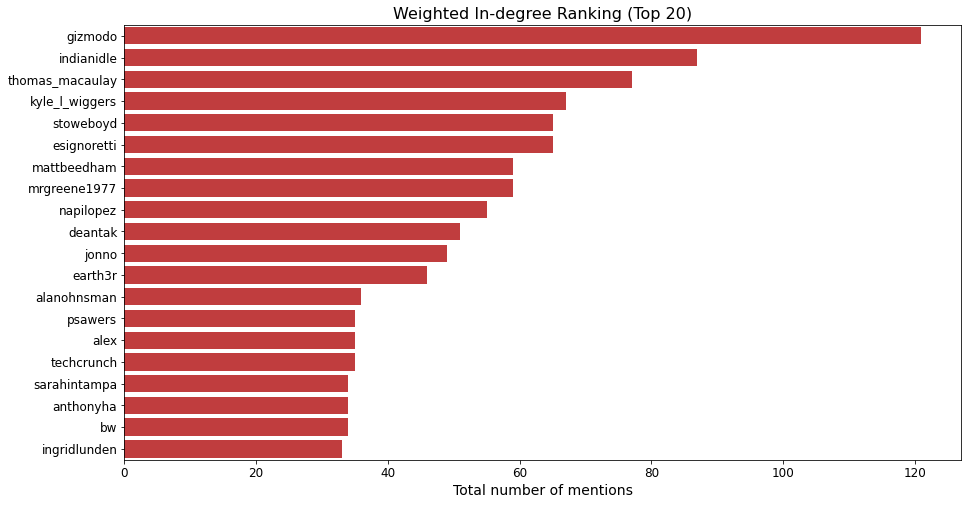

In [29]:
top_20_in = in_deg3.head(20)

plt.figure(figsize=(15, 8))
sns.barplot(data=top_20_in, x='win_degree', y=top_20_in.index, color='tab:red')
plt.title('Weighted In-degree Ranking (Top 20)', fontsize=16)
plt.xlabel('Total number of mentions', fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

Next, we can plot histograms for the two weighted degree measures.

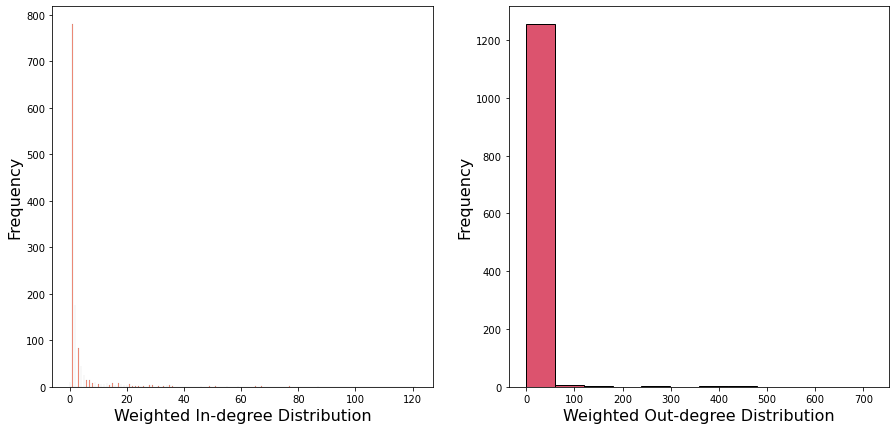

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.histplot(data=in_deg3, x='win_degree', color='#f86e51', ax=ax1)
ax1.set_xlabel('Weighted In-degree Distribution', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)

sns.histplot(data=out_deg3, x='wout_degree', color='#d1193e', ax=ax2)
ax2.set_xlabel('Weighted Out-degree Distribution', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)
plt.show()

The highly skewed distributions are evidence of the following:

- Weighted outgoing mentions are far greater in number compared to incoming mentions.
- The majority of degree scores are very low; there are only a handful of instances of nodes being mentioned (or mentioning others) frequently.

### Ego-centric Analysis

The top weighted in-degree account`@gizmodo` is clearly an important node (most incoming mentions) in the mention network, so it is worth constructing an ego network for it.

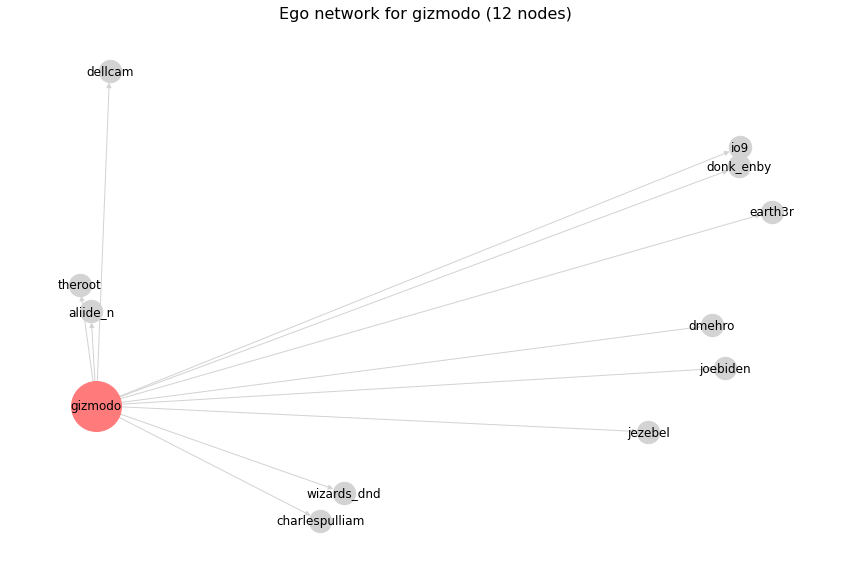

Ego: gizmodo
Number of nodes: 12
Number of edges: 12
Network density: 0.091
Average clustering coefficient: 0.000
Number of strongly connected components: 12
Number of weakly connected components: 1
Reciprocity: 0.000
Average in-degree: 1.000
Average out-degree: 1.000


In [31]:
mention_eg1 = ego_analysis(mention_net, 'gizmodo', ego_color='#ff7b7b')

Another node to consider would be `@telegraphtech`, which has the maximum weighted out-degree. The node labels are omitted to improve readability.

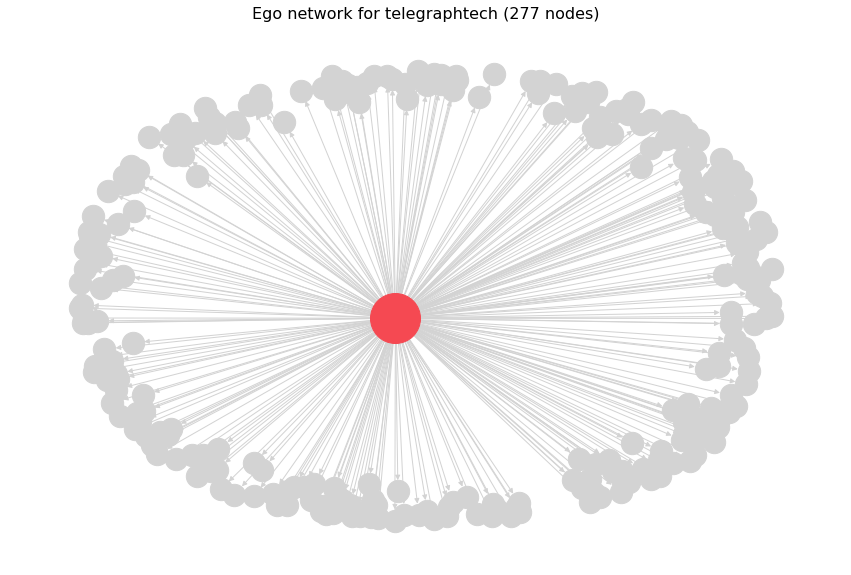

Ego: telegraphtech
Number of nodes: 277
Number of edges: 277
Network density: 0.004
Average clustering coefficient: 0.000
Number of strongly connected components: 277
Number of weakly connected components: 1
Reciprocity: 0.000
Average in-degree: 1.000
Average out-degree: 1.000


In [32]:
mention_eg2 = ego_analysis(mention_net, 'telegraphtech', 
                           ego_color='#f54952', with_labels=False)

Similar to the reply network, for both ego networks above, connections between alters are either negligible or non-existent.

### Network Visualisation

Using Gephi, the mention network can be visualised using the Fruchterman-Reingold layout. Interestingly, on applying modularity-based Louvain community finding (and colouring the nodes using this assignment), several clusters are identified in the network.

In [33]:
nx.write_gexf(mention_net, './out/mention_net.gexf', prettyprint=True)

<img src='./out/mention_net.png' width='750'>

Image: `./out/mention_net.png`

## User-hashtag Network

A user-hashtag network is a **weighted, bipartite network**, with edges going from the set of user nodes to the set of hashtags they use in their tweets. The number of times an account uses a hashtag is represented by edge weights.

### Construction

To construct the network, the initial steps are similar to the [reply](#Reply-Network) and [mention](#Mention-Network) networks. The relevant columns from the tweets DataFrame are copied, and the hashtags used are retrieved from the tweets' `entities`, while filtering out the tweets where no hashtags were used. The `#` symbol is prepended to hashtag names to prevent collision with user accounts having the same name. The tweet author's screen name and all hashtags are also converted to lowercase.

In [34]:
user_hashtag_df = tweets_df[['user', 'entities']].copy()

user_hashtag_df['hashtags'] = user_hashtag_df['entities'].apply(
    lambda e: e['hashtags'])

user_hashtag_df.drop(['entities'], axis=1, inplace=True)
user_hashtag_df = user_hashtag_df[user_hashtag_df['hashtags'].map(len) != 0]

user_hashtag_df['hashtags'] = user_hashtag_df['hashtags'].apply(
    lambda x: ['#' + u['text'].lower() for u in x])

user_hashtag_df['user'] = user_hashtag_df['user'].apply(
    lambda u: u['screen_name'].lower())

user_hashtag_df

,user,hashtags
2,rww,"[#microsoft, #google]"
5,gigaom,"[#devops, #devsecops, #softwaredevelopment]"
12,gigaom,"[#devops, #cicd, #value]"
16,gigaom,"[#datacenters, #cpu, #gpu, #datastorage, #nvmeof]"
21,rww,"[#technology, #blackfriday]"
...,...,...
14374,bbctech,[#xboxseriesx]
14384,cnet,[#growinggoals]
14388,gigaom,"[#objectstorage, #covid19, #storage, #cloud]"
14461,gigaom,"[#valuestream, #devops]"


Next, the hashtags are transformed to occupy one row each, instead of a list of hashtags per tweet. The frequency of unique _user-hashtag_ pairs are computed.

In [35]:
expl_hashtag_df = user_hashtag_df.explode('hashtags')
expl_hashtag_df = pd.DataFrame(expl_hashtag_df.value_counts(), 
                               columns=['num_uses'])
expl_hashtag_df.reset_index(inplace=True)
expl_hashtag_df.head()

,user,hashtags,num_uses
0,rww,#technology,111
1,gigaom,#devops,60
2,gigaom,#cloud,48
3,gigaom,#ai,43
4,telegraphtech,#techintel20,42


The bipartite network can now be created, by assigning the users (tweet authors) to set 0, and hashtags to set 1. Edges are added by operating on the edgelist above to take the (user, hashtag, edge attribute dictionary) format.

In [36]:
user_hashtag_net = nx.Graph()
user_hashtag_net.add_nodes_from(expl_hashtag_df['user'], bipartite=0)
user_hashtag_net.add_nodes_from(expl_hashtag_df['hashtags'], bipartite=1)
user_hashtag_net.add_edges_from([(u['user'], u['hashtags'], {'num_uses': u['num_uses']})
                                 for u in expl_hashtag_df.to_dict(orient='index').values()])

### Structural Characteristics

The basic structural characteristics of the bipartite network are shown below.

In [37]:
basic_chars(user_hashtag_net)
undirected_chars(user_hashtag_net)

Number of nodes: 730
Number of edges: 789
Network density: 0.003
Average clustering coefficient: 0.000
Average degree: 2.162
Number of connected components: 4
Number of nodes in largest component: 722


We find that the network isn't fully connected, and has 4 separate connected components. The number of nodes in each bipartite set are computed below. The `bipartite.sets()` algorithm *cannot* be used here due to the disconnected nature of the network.

In [38]:
users = set(n for n, d in user_hashtag_net.nodes(
    data=True) if d['bipartite'] == 0)
hashtags = set(n for n, d in user_hashtag_net.nodes(
    data=True) if d['bipartite'] == 1)

print(f'Number of users: {len(users)}')
print(f'Number of hashtags: {len(hashtags)}')

Number of users: 21
Number of hashtags: 709


Of the 730 nodes in the network, 21 are in set 0 (users) and 709 are in set 1 (hashtags). We can confirm the bipartite nature as follows:

In [39]:
nx.bipartite.is_bipartite(user_hashtag_net)

True

In [40]:
# neighbours of account @rww
list(user_hashtag_net.neighbors('rww'))[:10]

['#technology',
 '#apple',
 '#business',
 '#cybersecurity',
 '#google',
 '#tech',
 '#software',
 '#microsoft',
 '#innovation',
 '#ai']

In [41]:
# neighbours of hashtag #apple
list(user_hashtag_net.neighbors('#apple'))[:10]

['rww', 'cnntech']

### Weighted Degree Distributions

Weighted degree measures can be used to identify users using the most number of hashtags, as well as the individual hashstags being used most often.

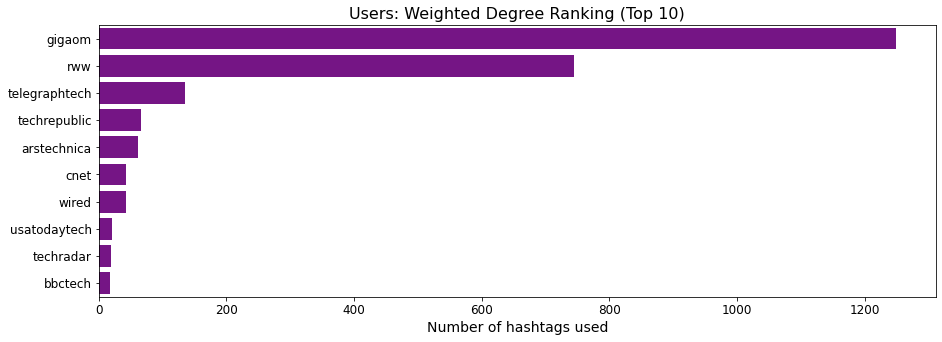

In [42]:
user_wdeg = pd.DataFrame(pd.Series(dict(user_hashtag_net.degree(
    users, weight='num_uses')), name='w_degree').sort_values(ascending=False))

top_10_user = user_wdeg.head(10)
plt.figure(figsize=(15, 5))
sns.barplot(data=top_10_user, x='w_degree',
            y=top_10_user.index, color='#820298')
plt.title('Users: Weighted Degree Ranking (Top 10)', fontsize=16)
plt.xlabel('Number of hashtags used', fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

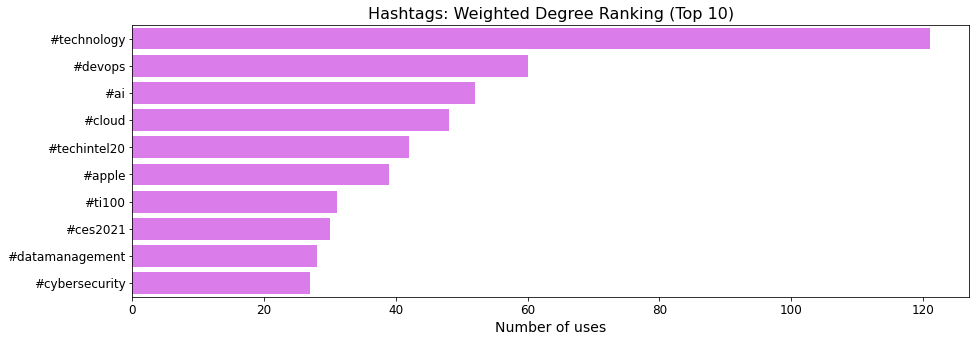

In [43]:
hashtag_wdeg = pd.DataFrame(pd.Series(dict(user_hashtag_net.degree(
    hashtags, weight='num_uses')), name='w_degree').sort_values(ascending=False))

top_10_hashtag = hashtag_wdeg.head(10)
plt.figure(figsize=(15, 5))
sns.barplot(data=top_10_hashtag, x='w_degree',
            y=top_10_hashtag.index, color='#e76afc')
plt.title('Hashtags: Weighted Degree Ranking (Top 10)', fontsize=16)
plt.xlabel('Number of uses', fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

The two bar charts above rank the top 10 users (in terms of number of hashtags used), and the top 10 hashtags (in terms of number of uses as well). For both charts, the length of the top ranked bar is nearly twice that of the second. The overall distribution of the weighted degree distributions for both users and hashtags are plotted below.

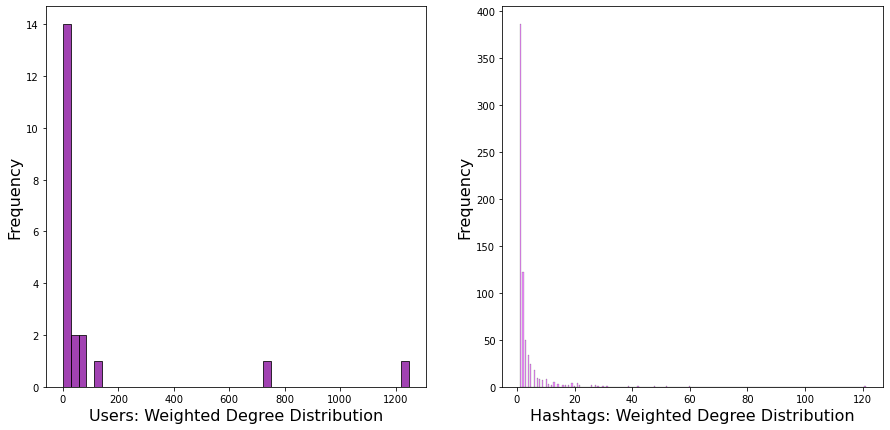

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.histplot(data=user_wdeg, x='w_degree', color='#820298', ax=ax1)
ax1.set_xlabel('Users: Weighted Degree Distribution', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)

sns.histplot(data=hashtag_wdeg, x='w_degree', color='#e76afc', ax=ax2)
ax2.set_xlabel('Hashtags: Weighted Degree Distribution', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)
plt.show()

As expected, the weighted degrees follow a power law distribution.

### Network Visualisation

A naive visualisation of the entire bipartite network (although not very useful), can be produced by specifying colours and positions for the two sets of nodes.

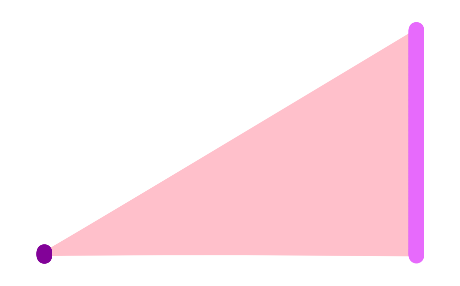

In [45]:
# manually set the node colours and positions
color_map, pos = {}, {}
for i, node in enumerate(users):
    pos[node] = (0, i*10)
    color_map[node] = '#820298'
for i, node in enumerate(hashtags):
    pos[node] = (0.5, 15 + i*15)
    color_map[node] = '#e76afc'
colors = [color_map[node] for node in user_hashtag_net.nodes()]


# draw the network
plt.figure(figsize=(8, 5))
plt.margins(0.1, 0.1)
nx.draw_networkx(user_hashtag_net, pos=pos, with_labels=False,
                 node_size=200, node_color=colors, edge_color='pink')
plt.axis('off')
plt.show()

### Network Projection

It is more interesting to create a weighted projection of the network onto the set of user nodes, and characterise the new network.

In [46]:
user_proj = nx.bipartite.weighted_projected_graph(user_hashtag_net, users)
basic_chars(user_proj)
undirected_chars(user_proj)

Number of nodes: 21
Number of edges: 71
Network density: 0.338
Average clustering coefficient: 0.682
Average degree: 6.762
Number of connected components: 4
Number of nodes in largest component: 18


The highest number of overlaps in terms of hashtags used can be computed by converting the network into an edgelist.

In [47]:
nx.to_pandas_edgelist(user_proj).sort_values(
    by='weight', ascending=False).head(10)

,source,target,weight
36,rww,gigaom,29
39,rww,techrepublic,5
37,rww,bbctech,4
55,techrepublic,gigaom,3
44,gizmodo,cnet,3
40,rww,telegraphtech,3
10,wired,telegraphtech,3
11,wired,arstechnica,3
50,cnet,bbctech,3
49,gizmodo,arstechnica,2


The table above proves that `@gigaom` and `@rww` have far more hashtag uses in common than any other pair of accounts. Moreover, the projection is a weighted, undirected network, which can be visualised using a circular layout below.

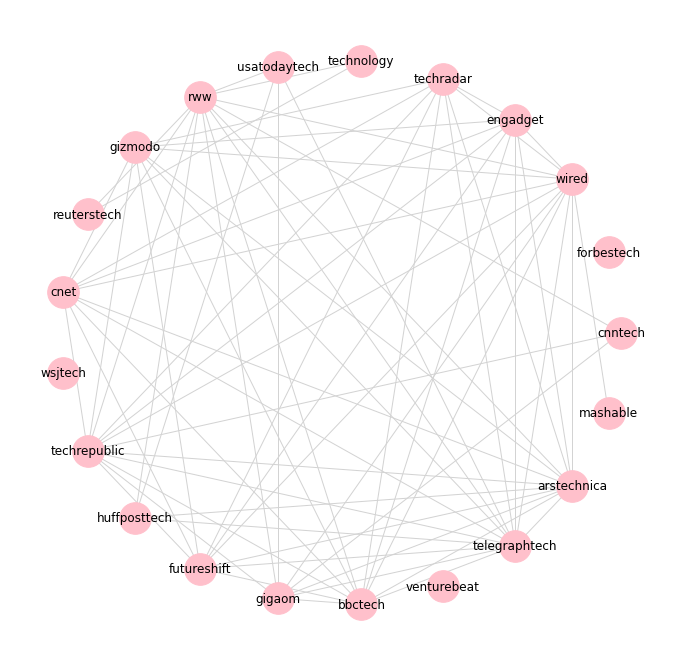

In [48]:
plt.figure(figsize=(12, 12))
plt.margins(0.1, 0.1)
pos = nx.circular_layout(user_proj)
nx.draw_networkx(user_proj, pos, with_labels=True, font_size=12,
                 node_size=1000, node_color='pink', edge_color='lightgrey')
plt.axis('off')
plt.show()

Using another weighted degree measure, the central nodes in the projected network can be obtained.

In [49]:
user_proj_wdeg = pd.DataFrame(pd.Series(dict(user_proj.degree(
    weight='num_uses')), name='w_degree').sort_values(ascending=False))

user_proj_wdeg.head(10)

,w_degree
telegraphtech,13
wired,12
arstechnica,12
rww,12
techrepublic,12
bbctech,11
cnet,10
futureshift,9
engadget,9
techradar,9


Since `@telegraphtech` has the highest weighted degree score, we can look at the ego network for that account. The alters in the ego network might be suggestive of similar accounts that use common hashtags.

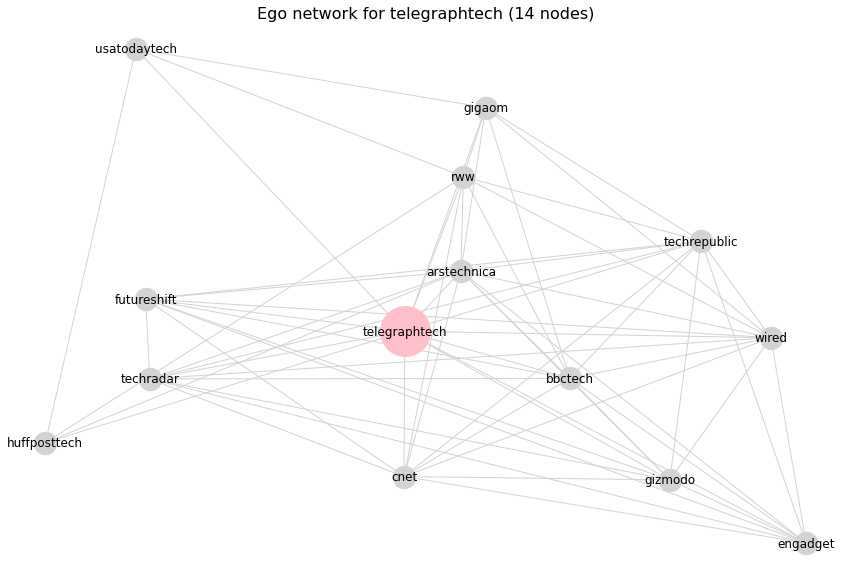

Ego: telegraphtech
Number of nodes: 14
Number of edges: 64
Network density: 0.703
Average clustering coefficient: 0.855
Average degree: 9.143
Number of connected components: 1
Diameter: 2
Average shortest path length: 1.297


In [50]:
user_eg = ego_analysis(user_proj, 'telegraphtech', ego_color='pink')

The high density, average clustering coefficient and average degree scores are significant, indicating that most of the alters in the ego network are also similar to each other and use common hashtags.

## Hashtag Co-occurrence Network

A hashtag co-occurrence network is **weighted, undirected network**, representing the various hashtags appearing in tweets authored by accounts in our list. The edge weights signify the frequency of co-occurrence for a pair of hashtags.

### Construction

The network can be created from the same DataFrame used to construct the [user-hashtag network](#User-hashtag-Network). Again, this DataFrame contains the tweet authors' screen names and lists of hashtags used.

In [51]:
user_hashtag_df.head()

,user,hashtags
2,rww,"[#microsoft, #google]"
5,gigaom,"[#devops, #devsecops, #softwaredevelopment]"
12,gigaom,"[#devops, #cicd, #value]"
16,gigaom,"[#datacenters, #cpu, #gpu, #datastorage, #nvmeof]"
21,rww,"[#technology, #blackfriday]"


The hashtags can be extracted and converted to a dictionary for faster iteration. Then, in every list of hashtags, all unique pair combinations are retrieved. Network edges are added between all such pairs of hashtags, and if an edge already exists, then its weight is incremented.

In [52]:
from itertools import combinations


hashtag_co_net = nx.Graph()
hashtag_co_dict = user_hashtag_df[['hashtags']].to_dict(orient='index')

for h in hashtag_co_dict.values():
    for h1, h2 in combinations(h['hashtags'], r=2):
        if hashtag_co_net.has_edge(h1, h2):
            weight = hashtag_co_net[h1][h2]['weight']
        else:
            weight = 0
        hashtag_co_net.add_edge(h1, h2, weight=weight+1)

### Structural Characteristics

In [53]:
basic_chars(hashtag_co_net)
undirected_chars(hashtag_co_net)

Number of nodes: 569
Number of edges: 1355
Network density: 0.008
Average clustering coefficient: 0.468
Average degree: 4.763
Number of connected components: 46
Number of nodes in largest component: 464


The basic characteristic measures of the network reveal a sparse, disconnected nature, although among the 46 different connected components, there does exist one large component comprising about 80% of all nodes.

### Edge Weight Distribution

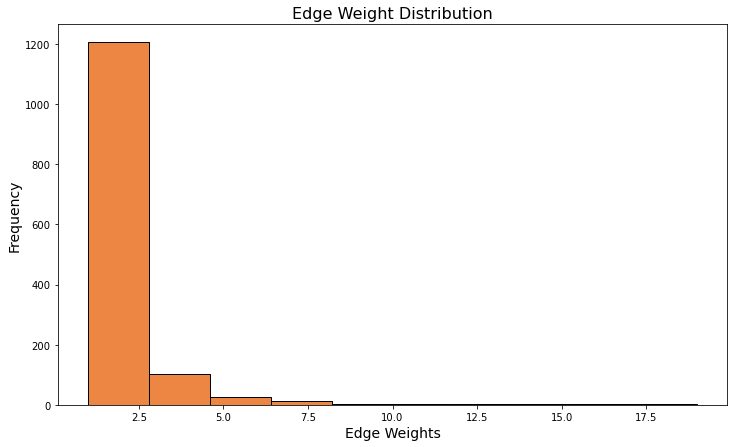

In [54]:
weights = [edge[-1]['weight'] for edge in hashtag_co_net.edges(data=True)]

plt.figure(figsize=(12, 7))
sns.histplot(data=weights, bins=10, color='#e85d04')
plt.title('Edge Weight Distribution', fontsize=16)
plt.xlabel('Edge Weights', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

A power law distribution is evident in the edge weights for the co-occurrence network.

### Top Co-occurrence Relationships

The pairs of hashtags that are most frequently used together can be computed, and the top 10 such instances are displayed below.

In [55]:
nx.to_pandas_edgelist(hashtag_co_net).sort_values(
    by='weight', ascending=False).head(10)

,source,target,weight
807,#ai,#aiops,19
33,#devops,#softwaredevelopment,17
41,#devops,#valuestreammanagement,14
32,#devops,#devsecops,14
45,#devops,#vsm,14
363,#k8s,#kubernetes,13
812,#ai,#ml,11
814,#ai,#machinelearning,11
600,#automation,#ai,9
874,#valuestreammanagement,#vsm,9


### Weighted Degree Distribution

Simple node degree statistics can be computed along with plotting the distribution.

Weighted degree range: [1, 161]
Mean weighted degree: 7.32
Median weighted degree: 3.00


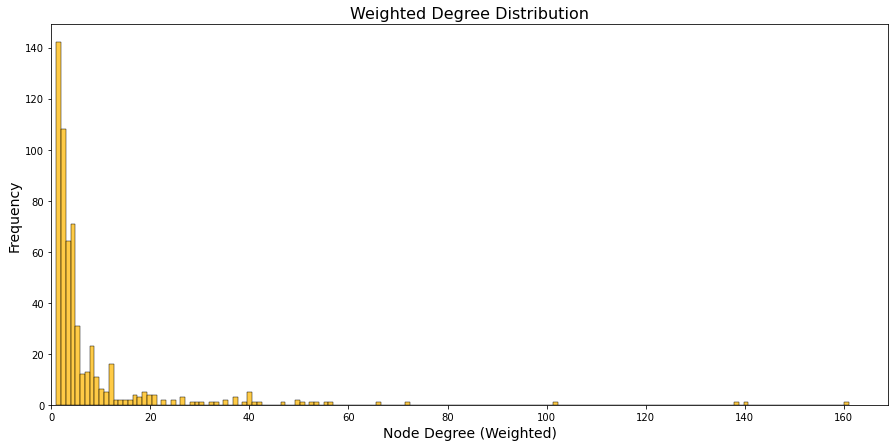

In [56]:
def degree_stats(net: nx.Graph) -> None:
    deg = pd.Series(dict(nx.degree(net, weight='weight')))
    print(f'Weighted degree range: [{deg.min()}, {deg.max()}]')
    print(f'Mean weighted degree: {deg.mean():.2f}')
    print(f'Median weighted degree: {deg.median():.2f}')

    plt.figure(figsize=(15, 7))
    sns.histplot(data=deg, color='#ffba08')
    plt.title(f'Weighted Degree Distribution', fontsize=16)
    plt.xlim(0)
    plt.xlabel('Node Degree (Weighted)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.show()


degree_stats(hashtag_co_net)

A familiar skewed distribution is obtained, with the frequency decreasing exponentially with increasing node degrees. A higher mean weighted degree compared to the median suggests the presence of a few outliers that affect the mean.

### Centrality Measures

A number of centrality measures can be computed for the co-occurrence network, to rank nodes based on different criteria.

**Degree centrality** can be computed by dividing the node degree scores by the maximum possible degree in the network, i.e., *n-1*, where *n* is the number of nodes in the network. It is appropriate when the number of connections in the network is important.

In [57]:
centrality_df = pd.DataFrame.from_dict(dict(nx.degree_centrality(
    hashtag_co_net)), orient='index', columns=['degree_centrality'])
centrality_df.sort_values(by='degree_centrality', ascending=False).head(5)

,degree_centrality
#technology,0.129
#cloud,0.129
#devops,0.111
#ai,0.090
#datastorage,0.062


Degree centrality does not capture the idea of brokerage. **Betweenness centrality** determines the relative importance of a node by measuring the amount of traffic flowing through that node to other nodes in the network. This is done by measuring the fraction of paths connecting all pairs of nodes and containing the node of interest. Strategic linkages, “brokers” or “bridging nodes” in a network are identified, and this measure is appropriate when control over information transmission is important. The **weighted** version of this measure takes into consideration the edge weights while computing shortest paths in the network.

In [58]:
centrality_df['wt_betweenness'] = pd.Series(dict(
    nx.betweenness_centrality(hashtag_co_net, weight='weight')))
centrality_df[['wt_betweenness']].sort_values(
    by='wt_betweenness', ascending=False).head(5)

,wt_betweenness
#technology,0.218
#devops,0.091
#security,0.091
#cloud,0.087
#enterpriseit,0.063


**Closeness centrality** determines how "close" a node is to other nodes in a network by measuring the sum of the shortest distances (geodesic paths) between that node and all other nodes in the network. This reflects on a node’s ability to access information through the "grapevine" of network members.

In [59]:
centrality_df['closeness'] = pd.Series(dict(
    nx.closeness_centrality(hashtag_co_net)))
centrality_df[['closeness']].sort_values(
    by='closeness', ascending=False).head(5)

,closeness
#technology,0.347
#ai,0.342
#devops,0.340
#cloud,0.335
#covid19,0.324


**Eigenvector centrality** is a more sophisticated version of degree centrality where the centrality of a node not only depends on the number of links incident on the node but also the quality of those links. This quality factor is determined by the eigenvectors of the adjacency matrix of the network. The **weighted** version is computed below, taking all the edge weights into account.

In [60]:
centrality_df['wt_eigenvector'] = pd.Series(dict(
    nx.eigenvector_centrality(hashtag_co_net, weight='weight')))
centrality_df[['wt_eigenvector']].sort_values(
    by='wt_eigenvector', ascending=False).head(5)

,wt_eigenvector
#devops,0.439
#ai,0.422
#aiops,0.314
#softwaredevelopment,0.252
#ml,0.233


All centrality measures are captured by the table below, and the hashtags are ordered by the weighted betweenness score.

In [61]:
centrality_df.sort_values(by='wt_betweenness', ascending=False)

,degree_centrality,wt_betweenness,closeness,wt_eigenvector
#technology,0.129,0.218,0.347,5.589e-02
#devops,0.111,0.091,0.340,4.388e-01
#security,0.044,0.091,0.317,3.223e-02
#cloud,0.129,0.087,0.335,2.021e-01
#enterpriseit,0.049,0.063,0.319,6.365e-02
...,...,...,...,...
#facemask,0.002,0.000,0.243,2.286e-03
#information,0.002,0.000,0.243,1.143e-03
#sql,0.002,0.000,0.238,4.133e-03
#ces2021,0.004,0.000,0.178,2.839e-05


The pairwise correlation between the different centrality measures is illustrated using a heatmap.

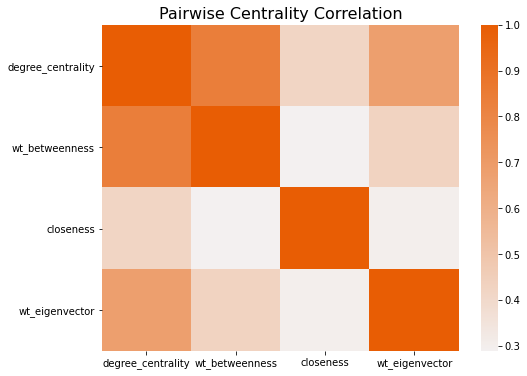

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=centrality_df.corr(),
            cmap=sns.light_palette('#e85d04', as_cmap=True))
plt.title('Pairwise Centrality Correlation', fontsize=16)
plt.show()

The strong positive correlation between degree centrality and weighted betweenness immediately stands out, suggesting that nodes with a high degree of edges are also the bridging nodes in the network.

### Ego-centric Analysis

In terms of node importance, `#technology` topped the list for degree, weighted betweenness as well as closeness centrality. This is not surprising, given that the Twitter list comprises technology related accounts. The hashtag `#devops` had the greatest weighted eigenvector centrality. Ego-centric analysis can be performed for these two hashtag nodes.

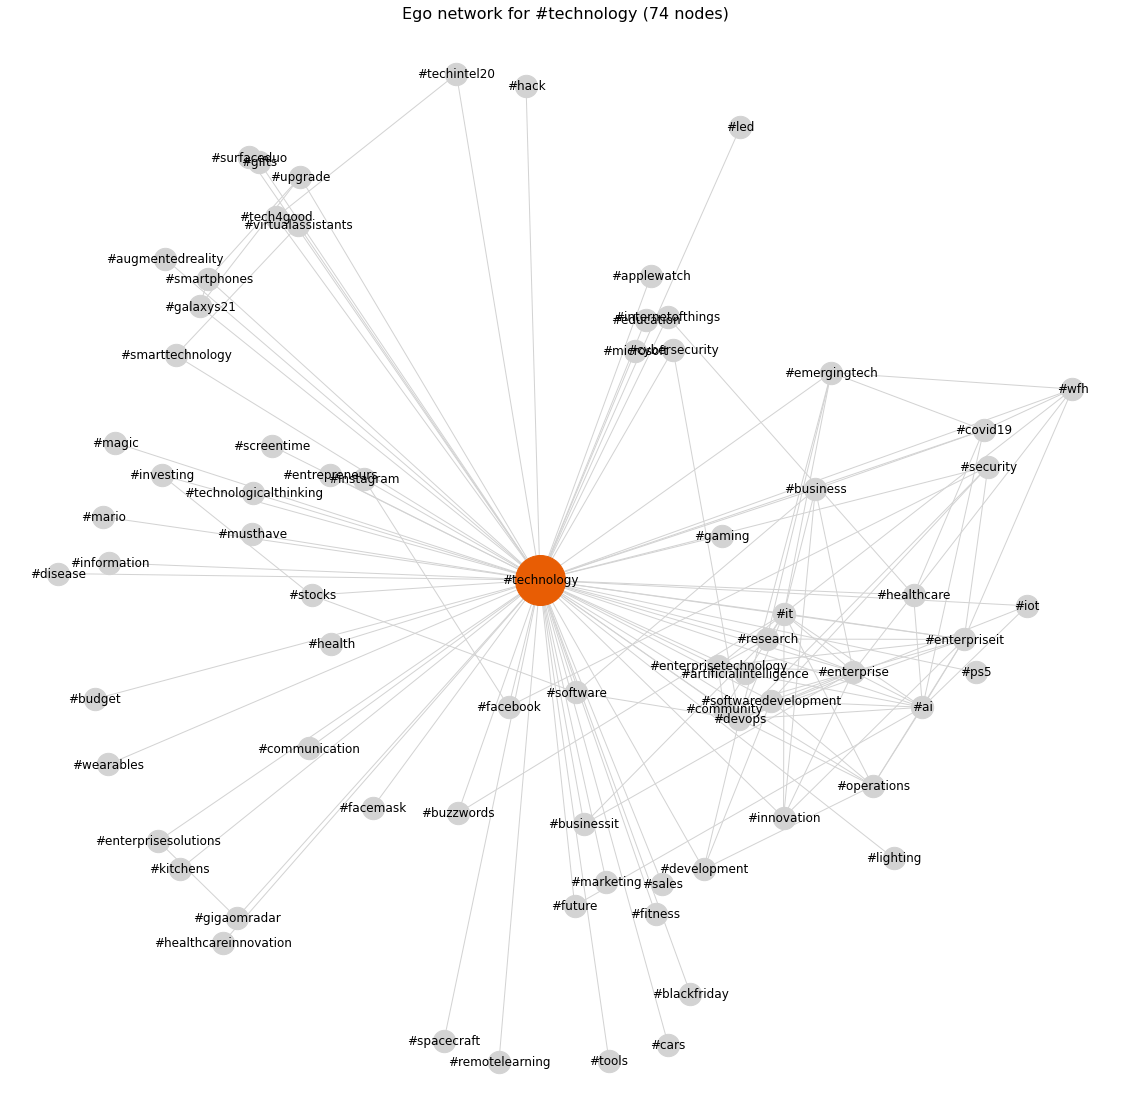

Ego: #technology
Number of nodes: 74
Number of edges: 149
Network density: 0.055
Average clustering coefficient: 0.424
Average degree: 4.027
Number of connected components: 1
Diameter: 2
Average shortest path length: 1.946


In [63]:
hashtag_co_eg1 = ego_analysis(
    hashtag_co_net, '#technology', ego_color='#e85d04', size='large', k=0.25)

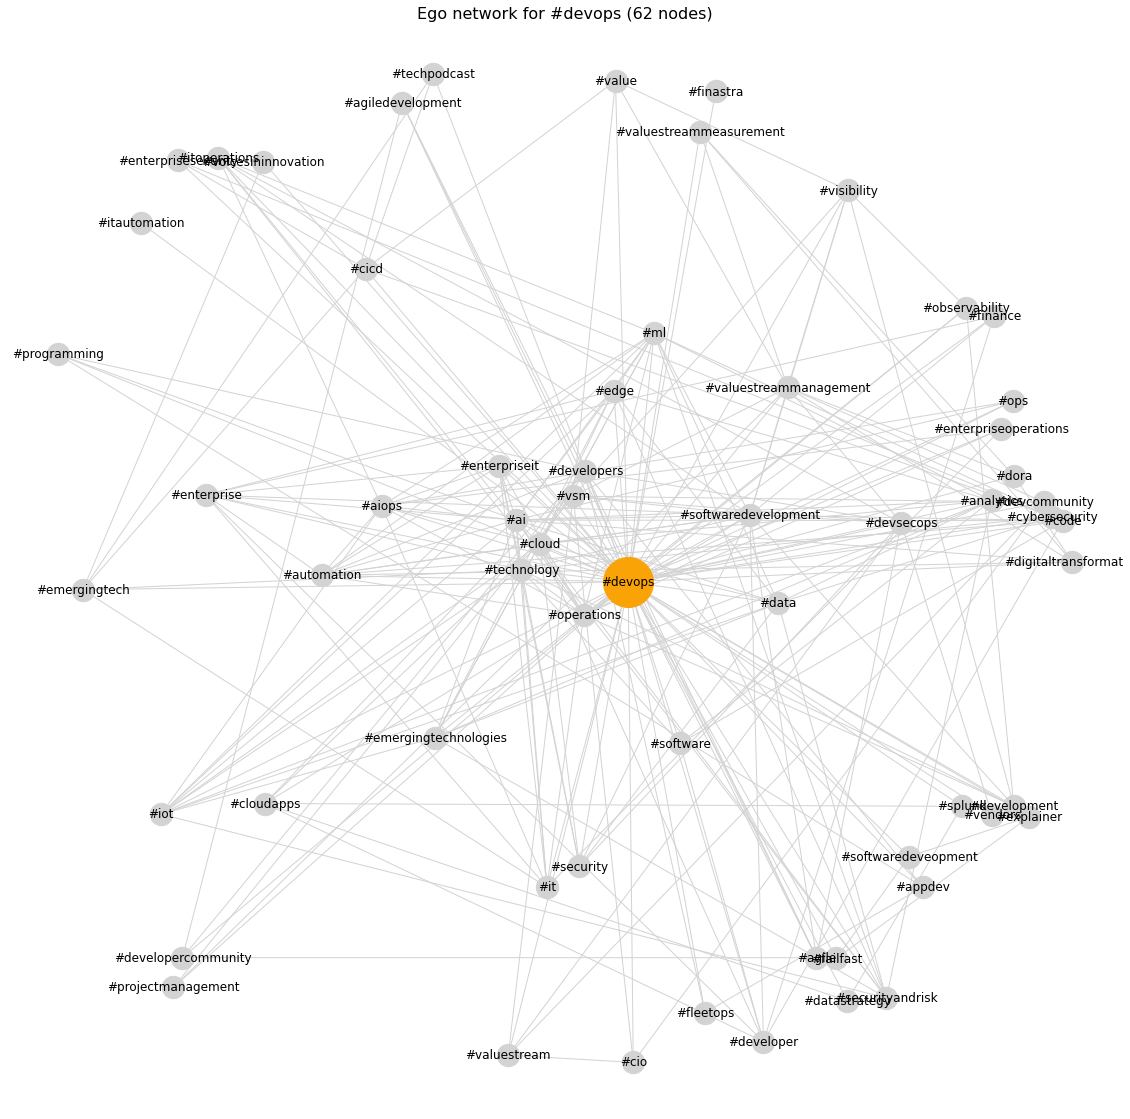

Ego: #devops
Number of nodes: 62
Number of edges: 248
Network density: 0.131
Average clustering coefficient: 0.704
Average degree: 8.000
Number of connected components: 1
Diameter: 2
Average shortest path length: 1.870


In [64]:
hashtag_co_eg2 = ego_analysis(
    hashtag_co_net, '#devops', ego_color='#faa307', size='large', k=1.25)

### Network Visualisaton

The entire hashtag co-occurrence network can be visualised in Gephi. The node sizes have been scaled by weighted degree values, and the edge thickness is proportional to weight. Nodes have been coloured according to assignments using the Louvain method for community detection, similar to the mention network. A large connected component can be identified at the centre of the network, with several small components in grey in the outskirts. The overall layout used is Fruchterman-Reingold.

In [65]:
nx.write_gexf(hashtag_co_net, './out/hashtag_co_net.gexf', prettyprint=True)

<img src='./out/hashtag_co_net.png' width='750'>

Image: `./out/hashtag_co_net.png`

## Conclusion

The five different types of networks reveal several interesting properties about users in the technology list. One can find similar patterns presenting themselves in various network characteristics. Looking at distributions of nodes degrees/edge weights, as well as ego networks for selected _important_ nodes, further helps in studying Twitter networks.